<a href="https://colab.research.google.com/github/muhammadhafiz27/Deep-Learning/blob/main/Autoencoder_untuk_Representasi_dan_Rekonstruksi_Citra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# **Fungsi Penambahan Noise Gaussian**

In [ ]:
def add_gaussian_noise(img, mean=0., std=0.1):
    """Menambahkan noise Gaussian ke tensor gambar."""
    # Menghasilkan tensor noise dengan shape yang sama
    noise = torch.randn(img.size()) * std + mean
    # Menambahkan noise
    noisy_img = img + noise
    # Mengklip nilai piksel agar tetap dalam rentang [0, 1]
    noisy_img = torch.clamp(noisy_img, 0., 1.)
    return noisy_img

# **Load dataset MNIST**

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# **Definisikan model Autoencoder**

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # Latent Dim = 3
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# **Training loop**

In [ ]:
epochs = 10
# Tentukan parameter noise yang digunakan untuk AE_2
NOISE_STD = 0.1 # Sesuai permintaan: Gaussian(0.1)

print(f"Memulai Training Denoising Autoencoder (Noise Std: {NOISE_STD})")
for epoch in range(epochs):
    for data, _ in trainloader:
        # img adalah target bersih (clean target)
        img = data.view(data.size(0), -1)

        # Tambahkan noise ke input
        noisy_img = add_gaussian_noise(img, std=NOISE_STD)

        # Forward pass menggunakan input ber-noise
        output = model(noisy_img)

        # Loss dihitung antara output model dan target bersih (img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Memulai Training Denoising Autoencoder (Noise Std: 0.1)
Epoch [1/10], Loss: 0.0546
Epoch [2/10], Loss: 0.0501
Epoch [3/10], Loss: 0.0453
Epoch [4/10], Loss: 0.0464
Epoch [5/10], Loss: 0.0434
Epoch [6/10], Loss: 0.0403
Epoch [7/10], Loss: 0.0392
Epoch [8/10], Loss: 0.0374
Epoch [9/10], Loss: 0.0399
Epoch [10/10], Loss: 0.0382


# **Visualisasi hasil rekonstruksi**

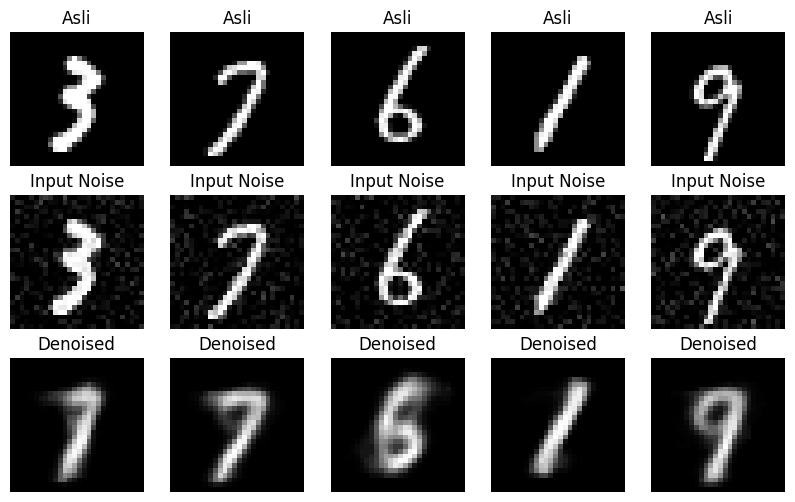

In [ ]:
with torch.no_grad():
    # Ambil 5 sampel bersih
    sample = next(iter(trainloader))[0][:5]

    # Tambahkan noise ke sampel untuk diuji
    noisy_sample = add_gaussian_noise(sample.view(-1, 28*28), std=NOISE_STD)

    # Rekonstruksi dari input ber-noise
    reconstructed = model(noisy_sample)

    # Ubah shape kembali ke citra 28x28
    noisy_sample = noisy_sample.view(-1, 1, 28, 28)
    sample = sample.view(-1, 1, 28, 28)
    reconstructed = reconstructed.view(-1, 1, 28, 28)

    fig, axes = plt.subplots(3, 5, figsize=(10,6))

    for i in range(5):
        # Baris 1: Citra Asli (Bersih)
        axes[0, i].imshow(sample[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Asli")
        axes[0, i].axis('off')

        # Baris 2: Input Ber-Noise
        axes[1, i].imshow(noisy_sample[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Input Noise")
        axes[1, i].axis('off')

        # Baris 3: Rekonstruksi (Bersih)
        axes[2, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[2, i].set_title("Denoised")
        axes[2, i].axis('off')

    plt.show()